In [2]:
from typing import Callable, Type

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as sp
from sympy import Function, dsolve, Eq
from sympy.abc import x, y

In [3]:
F = Callable[[float, float], float]  # Функция двух переменных F(x, y)
Array = np.ndarray[np.float32]

In [4]:
def Euler(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Эйлера.
    Порядок точности O(dx)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        y += dx * f(x, y)
        x += dx
        points.append((x, y))
    return np.array(points)

In [5]:
def RungeKuttas2(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Рунге-Кутты 2го порядка точности(метод Эйлера с пересчетом).
    Порядок точности O(dx^2)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        y_hat = y + dx * f(x, y)
        y += dx * (f(x, y) + f(x + dx, y_hat))/2
        x += dx
        points.append((x, y))
    return np.array(points)

In [6]:
def RungeKuttas4(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Рунге-Кутты 4го порядка точности.
    Порядок точности: O(dx^4)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        k1 = f(x, y)
        k2 = f(x + dx/2, y + k1*dx/2)
        k3 = f(x + dx/2, y + k2*dx/2)
        k4 = f(x + dx, y + k3*dx)
        y += dx * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x += dx
        points.append((x, y))
    return np.array(points)

In [7]:
def AdamsBashfort(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Адамса-Башфорта.
    Порядок точности: O(dx)
    """
    points = [(x0, y0), (x0 + dx, y0 + dx*f(x0, y0))]  # Метод Эйлера
    x, y = points[-1]
    for _ in range(1, n):
        x_i, y_i = points[-1]
        y += (3 * f(x, y) - f(x_i, y_i)) * dx / 2 
        x += dx
        points.append((x, y))
    return np.array(points)

In [8]:
def AdamsMultons(f: F, x0: float, y0: float, coef: list[float], n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Адамса-Мультона.
    Порядок точности: O(dx^k), гдe k = len(coef)
    """
    k = len(coef)
    points = [(x0, y0)]
    x, y = x0, y0
    # Первые шаги считаем через RK4
    for _ in range(k-1):
        k1 = f(x, y)
        k2 = f(x + dx/2, y + k1*dx/2)
        k3 = f(x + dx/2, y + k2*dx/2)
        k4 = f(x + dx, y + k3*dx)
        y += dx * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x += dx
        points.append((x, y))

    for _ in range(k, n):
        y_hat = coef[0] * f(x, y)
        for i in range(1, k):
            x_i, y_i = points[-i]
            y_hat += coef[i] * f(x_i, y_i)
        y += y_hat * dx
        x += dx
        points.append((x, y))
    return np.array(points)

# Параметры решения

**$f$ - исходная функция**  
$y'=f(x,y)$


In [9]:
def f(x: float, y: float):
    return y * np.sin(x) ** 2

# Или символьно через SymPy
y = Function("y")
eq = Eq(y(x).diff(x), sp.sin(x)**2 * y(x))

In [10]:
dx = 1e-2
x0, y0 = 0, 0.1
x1 = 10
n = abs(int((x1 - x0) / dx))


## Построение графика

In [11]:
def plot(exact: F, f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2, *, method: Type[F] = Euler):
    space = np.linspace(x0, round(dx * n), n)
    Y = exact(space)
    plt.plot(space, Y, label="Exact")
    T = method(f, x0, y0, n, dx)
    plt.plot(T[:, 0], T[:, 1], label=method.__name__, linestyle='--')
    T = odeint(f, y0, space, tfirst=True)
    plt.plot(space, T, label="Scikit", linestyle='--')
    
    plt.legend()
    plt.show()

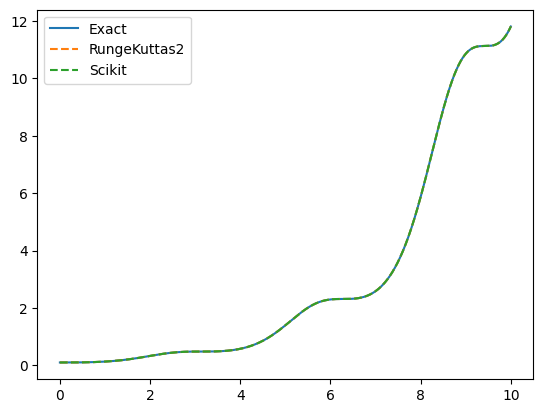

In [12]:


exact = lambda x: np.exp(x/2 - np.sin(2*x)/4 + np.log(0.1))

# Или символьно через SymPy
solution = dsolve(eq, y(x), ics={y(x0): y0})
exact = sp.lambdify(x, solution.rhs, "numpy")

plot(exact, f, x0, y0, method=RungeKuttas2)